In [1]:
from __future__ import print_function, division
import os
import torch
from torch import nn
import numpy as np
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13680640005410121692, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16435772255515924393
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1711588506814996370
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14254804173
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9135968640417181313
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
# import tarfile
# fname = 'data.tar.gz'
# if (fname.endswith("tar.gz")):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [0]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'clean')
        self.y_path = os.path.join(data_dir, 'distorted')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
            return len(self.x_files_paths)
        else:
            return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
      
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
 
            
        )
        self.out = nn.Sigmoid()

        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(32, 16, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(16, 3, (3, 3), padding=1),
#             nn.ReLU(inplace=True),
            
        )

    def forward(self, x):
#         residual = x
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
#         decoded = decoded + residual
        decoded = self.out(decoded)
        
        return encoded, decoded

In [0]:
class REDNet10(nn.Module):
    def __init__(self, num_layers=5, num_features=64):
        super(REDNet10, self).__init__()
        conv_layers = []
        deconv_layers = []

        conv_layers.append(nn.Sequential(nn.Conv2d(3, num_features, kernel_size=3, stride=2, padding=1),
                                         nn.ReLU(inplace=True)))
        for i in range(num_layers - 1):
            conv_layers.append(nn.Sequential(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
                                             nn.ReLU(inplace=True)))

        for i in range(num_layers - 1):
            deconv_layers.append(nn.Sequential(nn.ConvTranspose2d(num_features, num_features, kernel_size=3, padding=1),
                                               nn.ReLU(inplace=True)))
        deconv_layers.append(nn.ConvTranspose2d(num_features, 3, kernel_size=3, stride=2, padding=1, output_padding=1))

        self.conv_layers = nn.Sequential(*conv_layers)
        self.deconv_layers = nn.Sequential(*deconv_layers)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
#         residual = x
        out = self.conv_layers(x)
        out = self.deconv_layers(out)
#         out += residual
        out = self.relu(out)
        return out


In [6]:
# Hyper Parameters
epochs = 20
lr = 0.005
n_plots = 1
batch_size = 32
torch.manual_seed(42)

torch.Size([32, 3, 48, 48])
tensor([[[0.9176, 0.9216, 0.9451,  ..., 0.9255, 0.9608, 0.9882],
         [0.9686, 0.9569, 0.9451,  ..., 0.9294, 0.8824, 0.8471],
         [0.9765, 0.9647, 0.9490,  ..., 0.9255, 0.8078, 0.7059],
         ...,
         [0.3412, 0.3765, 0.5373,  ..., 0.9451, 0.9451, 0.9451],
         [0.3529, 0.4510, 0.6627,  ..., 0.8941, 0.8941, 0.8941],
         [0.3333, 0.4784, 0.7294,  ..., 0.9294, 0.9294, 0.9294]],

        [[0.9529, 0.9569, 0.9725,  ..., 0.9255, 0.9608, 0.9882],
         [1.0000, 0.9843, 0.9725,  ..., 0.9294, 0.8824, 0.8471],
         [1.0000, 0.9922, 0.9686,  ..., 0.9255, 0.8078, 0.7059],
         ...,
         [0.3059, 0.3412, 0.5020,  ..., 0.9451, 0.9451, 0.9451],
         [0.3176, 0.4157, 0.6275,  ..., 0.8941, 0.8941, 0.8941],
         [0.2980, 0.4431, 0.6941,  ..., 0.9294, 0.9294, 0.9294]],

        [[0.9804, 0.9843, 0.9961,  ..., 0.9255, 0.9608, 0.9882],
         [1.0000, 1.0000, 0.9961,  ..., 0.9294, 0.8824, 0.8471],
         [1.0000, 1.0000, 0.98

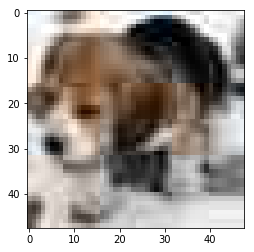

tensor([[[0.9412, 0.9569, 0.9412,  ..., 0.9765, 0.9373, 0.9059],
         [0.9647, 0.9608, 0.9804,  ..., 0.9412, 0.9333, 0.8471],
         [0.9490, 0.9647, 0.9451,  ..., 0.9373, 0.8667, 0.7529],
         ...,
         [0.3137, 0.3765, 0.4784,  ..., 0.9294, 0.9255, 0.9216],
         [0.2235, 0.3333, 0.7137,  ..., 0.9059, 0.8941, 0.9020],
         [0.2706, 0.5451, 0.8000,  ..., 0.8824, 0.9020, 0.9098]],

        [[0.9451, 0.9608, 0.9412,  ..., 0.9765, 0.9373, 0.9059],
         [0.9686, 0.9608, 0.9843,  ..., 0.9412, 0.9333, 0.8471],
         [0.9490, 0.9647, 0.9529,  ..., 0.9373, 0.8667, 0.7529],
         ...,
         [0.2980, 0.3608, 0.4549,  ..., 0.9333, 0.9294, 0.9255],
         [0.2196, 0.3294, 0.7098,  ..., 0.9216, 0.9098, 0.9176],
         [0.2745, 0.5490, 0.8039,  ..., 0.8980, 0.9176, 0.9255]],

        [[0.9647, 0.9765, 0.9333,  ..., 0.9686, 0.9294, 0.9059],
         [0.9843, 0.9608, 0.9647,  ..., 0.9333, 0.9333, 0.8471],
         [0.9490, 0.9569, 0.9333,  ..., 0.9373, 0.8745, 0.

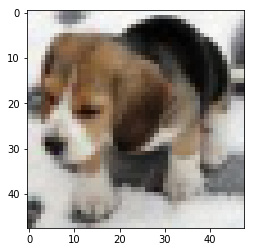

In [12]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

def show_img(image):
    print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    
show_img(train_dataset.get_train_data(5)[1][3])
show_img(train_dataset.get_train_data(5)[0][3])


0it [00:00, ?it/s]

Epoch:  0 | train loss: 0.0750
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


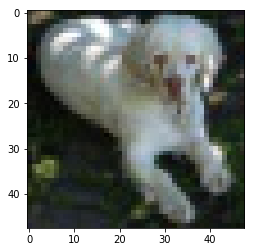

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

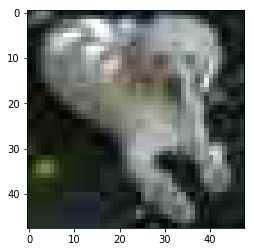

tensor([[[0.5309, 0.5302, 0.5309,  ..., 0.5313, 0.5332, 0.5312],
         [0.5347, 0.5310, 0.5335,  ..., 0.5365, 0.5376, 0.5325],
         [0.5329, 0.5301, 0.5327,  ..., 0.5366, 0.5376, 0.5334],
         ...,
         [0.5303, 0.5292, 0.5325,  ..., 0.5364, 0.5371, 0.5324],
         [0.5302, 0.5298, 0.5326,  ..., 0.5370, 0.5374, 0.5319],
         [0.5341, 0.5261, 0.5274,  ..., 0.5290, 0.5287, 0.5226]],

        [[0.5515, 0.5431, 0.5431,  ..., 0.5438, 0.5420, 0.5460],
         [0.5498, 0.5394, 0.5381,  ..., 0.5384, 0.5373, 0.5423],
         [0.5502, 0.5396, 0.5374,  ..., 0.5363, 0.5355, 0.5415],
         ...,
         [0.5505, 0.5389, 0.5358,  ..., 0.5358, 0.5365, 0.5410],
         [0.5502, 0.5398, 0.5368,  ..., 0.5373, 0.5383, 0.5414],
         [0.5503, 0.5412, 0.5399,  ..., 0.5414, 0.5421, 0.5449]],

        [[0.4807, 0.4721, 0.4709,  ..., 0.4733, 0.4767, 0.4851],
         [0.4876, 0.4776, 0.4754,  ..., 0.4773, 0.4801, 0.4831],
         [0.4874, 0.4751, 0.4724,  ..., 0.4739, 0.4772, 0.

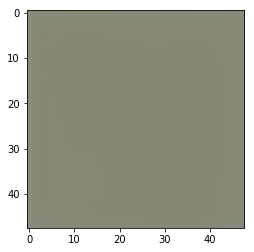


1it [00:00,  1.55it/s]
2it [00:00,  1.99it/s]
3it [00:00,  2.51it/s]
4it [00:01,  3.04it/s]
5it [00:01,  3.62it/s]
6it [00:01,  4.21it/s]
7it [00:01,  4.71it/s]
8it [00:01,  5.16it/s]
9it [00:01,  5.52it/s]
10it [00:02,  5.80it/s]
11it [00:02,  5.95it/s]
12it [00:02,  6.06it/s]
13it [00:02,  6.23it/s]
14it [00:02,  6.32it/s]
15it [00:02,  6.41it/s]
16it [00:02,  6.39it/s]
17it [00:03,  6.42it/s]
18it [00:03,  6.41it/s]
19it [00:03,  6.44it/s]
20it [00:03,  6.48it/s]
21it [00:03,  6.50it/s]
22it [00:03,  6.46it/s]
23it [00:04,  6.55it/s]
24it [00:04,  6.40it/s]
25it [00:04,  6.43it/s]
26it [00:04,  6.41it/s]
27it [00:04,  6.46it/s]
28it [00:04,  6.46it/s]
29it [00:04,  6.50it/s]
30it [00:05,  6.55it/s]
31it [00:05,  6.45it/s]
32it [00:05,  6.45it/s]
33it [00:05,  6.47it/s]
34it [00:05,  6.49it/s]
35it [00:05,  6.56it/s]
36it [00:06,  6.49it/s]
37it [00:06,  6.52it/s]
38it [00:06,  6.44it/s]
39it [00:06,  6.48it/s]
40it [00:06,  6.46it/s]
41it [00:06,  6.44it/s]
42it [00:06,  6.50it/s]


Epoch:  0 | train loss: 0.0134
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


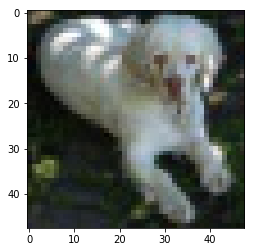

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

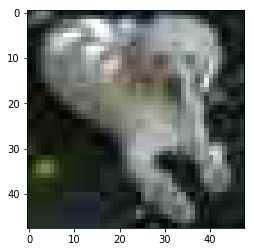

tensor([[[0.3157, 0.2562, 0.2733,  ..., 0.1011, 0.1248, 0.2183],
         [0.2153, 0.1419, 0.1754,  ..., 0.0342, 0.0434, 0.1101],
         [0.1940, 0.1292, 0.1856,  ..., 0.0465, 0.0506, 0.1115],
         ...,
         [0.1872, 0.0930, 0.0965,  ..., 0.0635, 0.0760, 0.1495],
         [0.2208, 0.1176, 0.1169,  ..., 0.0722, 0.0882, 0.1648],
         [0.3215, 0.1940, 0.1867,  ..., 0.1175, 0.1331, 0.2043]],

        [[0.3731, 0.2653, 0.2830,  ..., 0.1137, 0.1224, 0.2391],
         [0.2516, 0.1420, 0.1716,  ..., 0.0384, 0.0432, 0.1305],
         [0.2342, 0.1326, 0.1881,  ..., 0.0571, 0.0550, 0.1480],
         ...,
         [0.2073, 0.0853, 0.0905,  ..., 0.0639, 0.0716, 0.1750],
         [0.2343, 0.1081, 0.1095,  ..., 0.0711, 0.0824, 0.1906],
         [0.3005, 0.1729, 0.1717,  ..., 0.1121, 0.1296, 0.2563]],

        [[0.2423, 0.2147, 0.2162,  ..., 0.0687, 0.0914, 0.1752],
         [0.1888, 0.1532, 0.1649,  ..., 0.0382, 0.0505, 0.1031],
         [0.1683, 0.1366, 0.1615,  ..., 0.0439, 0.0528, 0.

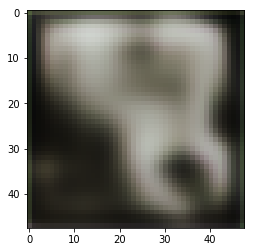


101it [00:16,  3.28it/s]
102it [00:16,  3.78it/s]
103it [00:16,  4.36it/s]
104it [00:16,  4.91it/s]
105it [00:17,  5.34it/s]
106it [00:17,  5.69it/s]
107it [00:17,  5.97it/s]
108it [00:17,  6.17it/s]
109it [00:17,  6.32it/s]
110it [00:17,  6.40it/s]
111it [00:17,  6.50it/s]
112it [00:18,  6.58it/s]
113it [00:18,  6.64it/s]
114it [00:18,  6.60it/s]
115it [00:18,  6.53it/s]
116it [00:18,  6.62it/s]
117it [00:18,  6.70it/s]
118it [00:19,  6.76it/s]
119it [00:19,  6.73it/s]
120it [00:19,  6.56it/s]
121it [00:19,  6.64it/s]
122it [00:19,  6.57it/s]
123it [00:19,  6.70it/s]
124it [00:19,  6.76it/s]
125it [00:20,  6.69it/s]
126it [00:20,  6.76it/s]
127it [00:20,  6.73it/s]
128it [00:20,  6.82it/s]
129it [00:20,  6.71it/s]
130it [00:20,  6.69it/s]
131it [00:20,  6.71it/s]
132it [00:21,  6.65it/s]
133it [00:21,  6.68it/s]
134it [00:21,  6.65it/s]
135it [00:21,  6.73it/s]
136it [00:21,  6.62it/s]
137it [00:21,  6.65it/s]
138it [00:22,  6.67it/s]
139it [00:22,  6.67it/s]
140it [00:22,  6.66it/s]

Epoch:  0 | train loss: 0.0126
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


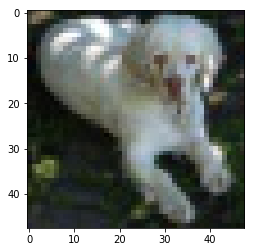

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

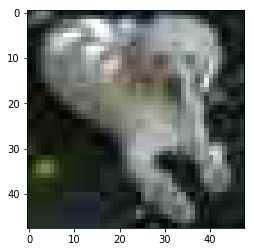

tensor([[[0.3316, 0.2759, 0.2606,  ..., 0.0535, 0.0736, 0.1425],
         [0.2060, 0.1522, 0.1570,  ..., 0.0157, 0.0221, 0.0602],
         [0.1516, 0.1102, 0.1362,  ..., 0.0223, 0.0254, 0.0590],
         ...,
         [0.1553, 0.0863, 0.0866,  ..., 0.0319, 0.0398, 0.0855],
         [0.1826, 0.1050, 0.1011,  ..., 0.0381, 0.0483, 0.0988],
         [0.2638, 0.1593, 0.1495,  ..., 0.0658, 0.0768, 0.1424]],

        [[0.3490, 0.2960, 0.2981,  ..., 0.0560, 0.0709, 0.1549],
         [0.2229, 0.1594, 0.1771,  ..., 0.0175, 0.0226, 0.0683],
         [0.1702, 0.1203, 0.1647,  ..., 0.0287, 0.0295, 0.0753],
         ...,
         [0.1569, 0.0751, 0.0802,  ..., 0.0308, 0.0367, 0.0929],
         [0.1827, 0.0938, 0.0951,  ..., 0.0377, 0.0456, 0.1097],
         [0.2345, 0.1302, 0.1281,  ..., 0.0548, 0.0661, 0.1595]],

        [[0.2712, 0.2452, 0.2284,  ..., 0.0371, 0.0537, 0.1150],
         [0.1879, 0.1607, 0.1628,  ..., 0.0175, 0.0251, 0.0572],
         [0.1422, 0.1202, 0.1399,  ..., 0.0233, 0.0287, 0.

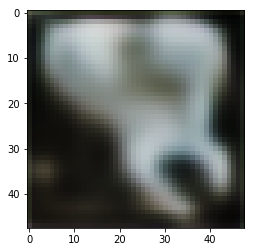


201it [00:32,  3.11it/s]
202it [00:32,  3.64it/s]
203it [00:32,  4.19it/s]
204it [00:32,  4.70it/s]
205it [00:32,  5.12it/s]
206it [00:32,  5.46it/s]
207it [00:33,  5.67it/s]
208it [00:33,  5.87it/s]
209it [00:33,  6.04it/s]
210it [00:33,  6.17it/s]
211it [00:33,  6.24it/s]
212it [00:33,  6.30it/s]
213it [00:34,  6.30it/s]
214it [00:34,  6.32it/s]
215it [00:34,  6.40it/s]
216it [00:34,  6.42it/s]
217it [00:34,  6.47it/s]
218it [00:34,  6.47it/s]
219it [00:34,  6.52it/s]
220it [00:35,  6.45it/s]
221it [00:35,  6.40it/s]
222it [00:35,  6.40it/s]
223it [00:35,  6.43it/s]
224it [00:35,  6.39it/s]
225it [00:35,  6.42it/s]
226it [00:36,  6.34it/s]
227it [00:36,  6.29it/s]
228it [00:36,  6.43it/s]
229it [00:36,  6.52it/s]
230it [00:36,  6.57it/s]
231it [00:36,  6.58it/s]
232it [00:36,  6.56it/s]
233it [00:37,  6.50it/s]
234it [00:37,  6.52it/s]
235it [00:37,  6.53it/s]
236it [00:37,  6.53it/s]
237it [00:37,  6.52it/s]
238it [00:37,  6.52it/s]
239it [00:38,  6.51it/s]
240it [00:38,  6.46it/s]

Epoch:  0 | train loss: 0.0093
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


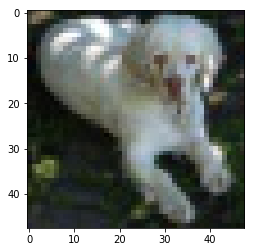

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

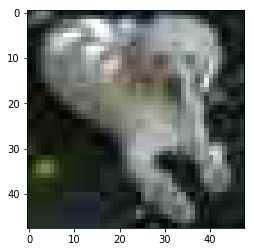

tensor([[[0.3423, 0.2815, 0.2473,  ..., 0.0583, 0.0819, 0.1496],
         [0.2001, 0.1663, 0.1543,  ..., 0.0258, 0.0374, 0.0823],
         [0.1382, 0.1182, 0.1300,  ..., 0.0383, 0.0447, 0.0827],
         ...,
         [0.1402, 0.0890, 0.0902,  ..., 0.0388, 0.0496, 0.0931],
         [0.1670, 0.1079, 0.1060,  ..., 0.0500, 0.0649, 0.1153],
         [0.2465, 0.1674, 0.1641,  ..., 0.0903, 0.1061, 0.1715]],

        [[0.3244, 0.3063, 0.2984,  ..., 0.0564, 0.0754, 0.1620],
         [0.2002, 0.1670, 0.1766,  ..., 0.0238, 0.0307, 0.0779],
         [0.1394, 0.1171, 0.1562,  ..., 0.0430, 0.0430, 0.0889],
         ...,
         [0.1465, 0.0829, 0.0954,  ..., 0.0422, 0.0482, 0.0992],
         [0.1811, 0.1108, 0.1200,  ..., 0.0583, 0.0664, 0.1250],
         [0.2221, 0.1359, 0.1384,  ..., 0.0719, 0.0844, 0.1717]],

        [[0.2796, 0.2603, 0.2380,  ..., 0.0405, 0.0573, 0.1185],
         [0.1847, 0.1649, 0.1645,  ..., 0.0220, 0.0313, 0.0676],
         [0.1280, 0.1103, 0.1263,  ..., 0.0288, 0.0355, 0.

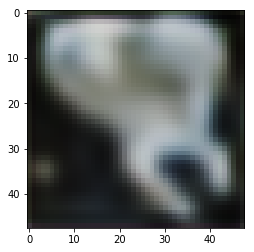


301it [00:48,  3.17it/s]
302it [00:48,  3.68it/s]
303it [00:48,  4.22it/s]
304it [00:48,  4.76it/s]
305it [00:48,  5.21it/s]
306it [00:48,  5.62it/s]
307it [00:49,  5.92it/s]
308it [00:49,  6.11it/s]
309it [00:49,  6.27it/s]
310it [00:49,  6.31it/s]
311it [00:49,  6.43it/s]
312it [00:49,  6.47it/s]
313it [00:49,  6.28it/s]
0it [00:00, ?it/s]

Epoch:  1 | train loss: 0.0086
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


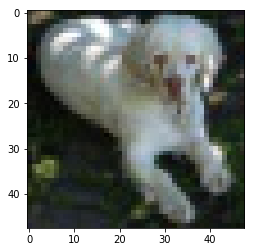

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

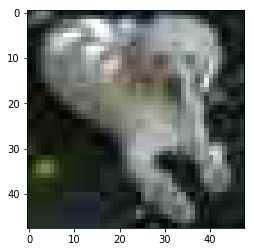

tensor([[[0.3344, 0.2759, 0.2372,  ..., 0.0520, 0.0762, 0.1415],
         [0.1842, 0.1526, 0.1369,  ..., 0.0210, 0.0325, 0.0741],
         [0.1219, 0.1022, 0.1090,  ..., 0.0299, 0.0370, 0.0720],
         ...,
         [0.1237, 0.0773, 0.0788,  ..., 0.0318, 0.0420, 0.0820],
         [0.1525, 0.0981, 0.0970,  ..., 0.0423, 0.0574, 0.1056],
         [0.2355, 0.1575, 0.1556,  ..., 0.0791, 0.0961, 0.1627]],

        [[0.3007, 0.2741, 0.2609,  ..., 0.0431, 0.0613, 0.1425],
         [0.1746, 0.1341, 0.1376,  ..., 0.0162, 0.0224, 0.0623],
         [0.1152, 0.0867, 0.1139,  ..., 0.0277, 0.0296, 0.0675],
         ...,
         [0.1247, 0.0659, 0.0768,  ..., 0.0318, 0.0373, 0.0816],
         [0.1632, 0.0944, 0.1031,  ..., 0.0461, 0.0542, 0.1059],
         [0.2032, 0.1188, 0.1222,  ..., 0.0576, 0.0703, 0.1516]],

        [[0.2531, 0.2247, 0.1988,  ..., 0.0302, 0.0462, 0.1055],
         [0.1499, 0.1223, 0.1176,  ..., 0.0139, 0.0223, 0.0559],
         [0.0957, 0.0730, 0.0816,  ..., 0.0171, 0.0237, 0.

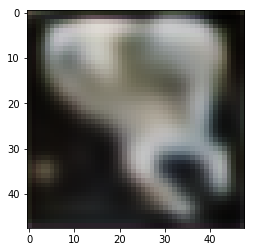


1it [00:00,  1.13it/s]
2it [00:01,  1.49it/s]
3it [00:01,  1.94it/s]
4it [00:01,  2.46it/s]
5it [00:01,  3.04it/s]
6it [00:01,  3.61it/s]
7it [00:01,  4.17it/s]
8it [00:01,  4.70it/s]
9it [00:02,  5.12it/s]
10it [00:02,  5.53it/s]
11it [00:02,  5.87it/s]
12it [00:02,  6.12it/s]
13it [00:02,  6.24it/s]
14it [00:02,  6.42it/s]
15it [00:03,  6.45it/s]
16it [00:03,  6.59it/s]
17it [00:03,  6.60it/s]
18it [00:03,  6.60it/s]
19it [00:03,  6.58it/s]
20it [00:03,  6.57it/s]
21it [00:03,  6.54it/s]
22it [00:04,  6.61it/s]
23it [00:04,  6.60it/s]
24it [00:04,  6.55it/s]
25it [00:04,  6.57it/s]
26it [00:04,  6.56it/s]
27it [00:04,  6.60it/s]
28it [00:04,  6.60it/s]
29it [00:05,  6.59it/s]
30it [00:05,  6.58it/s]
31it [00:05,  6.63it/s]
32it [00:05,  6.66it/s]
33it [00:05,  6.52it/s]
34it [00:05,  6.54it/s]
35it [00:06,  6.57it/s]
36it [00:06,  6.63it/s]
37it [00:06,  6.66it/s]
38it [00:06,  6.69it/s]
39it [00:06,  6.69it/s]
40it [00:06,  6.58it/s]
41it [00:06,  6.58it/s]
42it [00:07,  6.58it/s]


Epoch:  1 | train loss: 0.0090
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


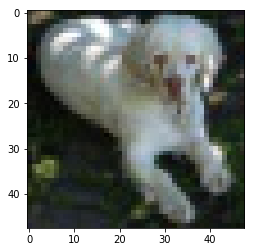

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

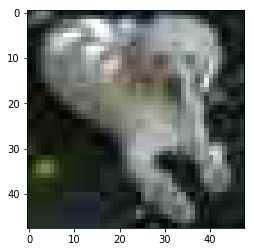

tensor([[[0.3693, 0.3325, 0.3108,  ..., 0.0595, 0.0841, 0.1437],
         [0.2003, 0.1982, 0.2005,  ..., 0.0386, 0.0549, 0.0951],
         [0.1267, 0.1289, 0.1545,  ..., 0.0683, 0.0762, 0.1061],
         ...,
         [0.1430, 0.1099, 0.1205,  ..., 0.0649, 0.0790, 0.1173],
         [0.1639, 0.1252, 0.1311,  ..., 0.0803, 0.0987, 0.1423],
         [0.2354, 0.1768, 0.1820,  ..., 0.1212, 0.1381, 0.1957]],

        [[0.2990, 0.3130, 0.3220,  ..., 0.0489, 0.0697, 0.1521],
         [0.1783, 0.1735, 0.2000,  ..., 0.0273, 0.0367, 0.0827],
         [0.1102, 0.1083, 0.1586,  ..., 0.0567, 0.0584, 0.1024],
         ...,
         [0.1406, 0.0993, 0.1257,  ..., 0.0649, 0.0703, 0.1153],
         [0.1687, 0.1177, 0.1363,  ..., 0.0794, 0.0870, 0.1355],
         [0.2052, 0.1311, 0.1404,  ..., 0.0820, 0.0950, 0.1737]],

        [[0.2870, 0.2864, 0.2682,  ..., 0.0386, 0.0573, 0.1176],
         [0.1791, 0.1741, 0.1807,  ..., 0.0259, 0.0392, 0.0797],
         [0.1148, 0.1081, 0.1295,  ..., 0.0417, 0.0540, 0.

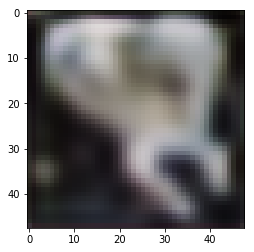


101it [00:16,  3.23it/s]
102it [00:16,  3.76it/s]
103it [00:16,  4.33it/s]
104it [00:17,  4.77it/s]
105it [00:17,  5.20it/s]
106it [00:17,  5.57it/s]
107it [00:17,  5.87it/s]
108it [00:17,  6.06it/s]
109it [00:17,  6.20it/s]
110it [00:17,  6.28it/s]
111it [00:18,  6.27it/s]
112it [00:18,  6.38it/s]
113it [00:18,  6.47it/s]
114it [00:18,  6.50it/s]
115it [00:18,  6.54it/s]
116it [00:18,  6.58it/s]
117it [00:19,  6.67it/s]
118it [00:19,  6.59it/s]
119it [00:19,  6.64it/s]
120it [00:19,  6.61it/s]
121it [00:19,  6.60it/s]
122it [00:19,  6.58it/s]
123it [00:19,  6.62it/s]
124it [00:20,  6.50it/s]
125it [00:20,  6.58it/s]
126it [00:20,  6.63it/s]
127it [00:20,  6.64it/s]
128it [00:20,  6.62it/s]
129it [00:20,  6.67it/s]
130it [00:20,  6.68it/s]
131it [00:21,  6.25it/s]
132it [00:21,  6.37it/s]
133it [00:21,  6.49it/s]
134it [00:21,  6.51it/s]
135it [00:21,  6.58it/s]
136it [00:21,  6.58it/s]
137it [00:22,  6.48it/s]
138it [00:22,  6.42it/s]
139it [00:22,  6.42it/s]
140it [00:22,  6.36it/s]

Epoch:  1 | train loss: 0.0089
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


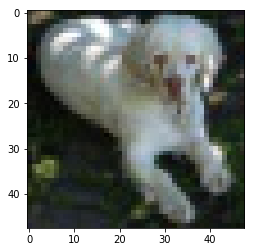

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

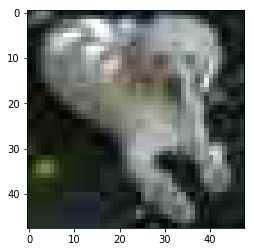

tensor([[[0.3282, 0.2805, 0.2562,  ..., 0.0389, 0.0588, 0.1154],
         [0.1702, 0.1580, 0.1552,  ..., 0.0245, 0.0380, 0.0759],
         [0.1016, 0.0962, 0.1125,  ..., 0.0450, 0.0560, 0.0894],
         ...,
         [0.1092, 0.0840, 0.0977,  ..., 0.0484, 0.0595, 0.0929],
         [0.1271, 0.0950, 0.1030,  ..., 0.0590, 0.0730, 0.1117],
         [0.1947, 0.1397, 0.1460,  ..., 0.0918, 0.1052, 0.1620]],

        [[0.2886, 0.2987, 0.3037,  ..., 0.0389, 0.0569, 0.1318],
         [0.1601, 0.1586, 0.1832,  ..., 0.0246, 0.0340, 0.0788],
         [0.0932, 0.0951, 0.1401,  ..., 0.0540, 0.0589, 0.1040],
         ...,
         [0.1116, 0.0876, 0.1205,  ..., 0.0583, 0.0628, 0.0980],
         [0.1342, 0.1003, 0.1233,  ..., 0.0702, 0.0772, 0.1162],
         [0.1649, 0.1046, 0.1172,  ..., 0.0646, 0.0770, 0.1485]],

        [[0.2466, 0.2313, 0.2089,  ..., 0.0250, 0.0390, 0.0899],
         [0.1437, 0.1271, 0.1261,  ..., 0.0161, 0.0258, 0.0591],
         [0.0836, 0.0702, 0.0809,  ..., 0.0284, 0.0400, 0.

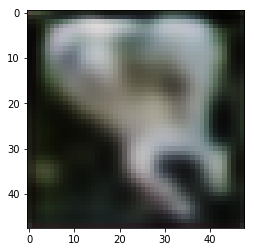


201it [00:32,  3.06it/s]
202it [00:32,  3.56it/s]
203it [00:32,  4.10it/s]
204it [00:33,  4.56it/s]
205it [00:33,  5.01it/s]
206it [00:33,  5.43it/s]
207it [00:33,  5.62it/s]
208it [00:33,  5.88it/s]
209it [00:33,  6.03it/s]
210it [00:33,  6.18it/s]
211it [00:34,  6.26it/s]
212it [00:34,  6.33it/s]
213it [00:34,  6.37it/s]
214it [00:34,  6.32it/s]
215it [00:34,  6.34it/s]
216it [00:34,  6.37it/s]
217it [00:35,  6.46it/s]
218it [00:35,  6.40it/s]
219it [00:35,  6.42it/s]
220it [00:35,  6.33it/s]
221it [00:35,  6.34it/s]
222it [00:35,  6.40it/s]
223it [00:35,  6.37it/s]
224it [00:36,  6.37it/s]
225it [00:36,  6.39it/s]
226it [00:36,  6.45it/s]
227it [00:36,  6.33it/s]
228it [00:36,  6.33it/s]
229it [00:36,  6.32it/s]
230it [00:37,  6.22it/s]
231it [00:37,  6.25it/s]
232it [00:37,  6.18it/s]
233it [00:37,  6.07it/s]
234it [00:37,  6.15it/s]
235it [00:37,  6.25it/s]
236it [00:38,  6.31it/s]
237it [00:38,  6.36it/s]
238it [00:38,  6.42it/s]
239it [00:38,  6.42it/s]
240it [00:38,  6.30it/s]

Epoch:  1 | train loss: 0.0082
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


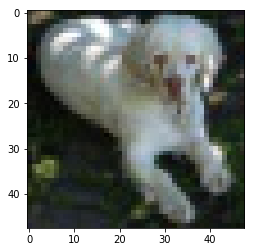

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

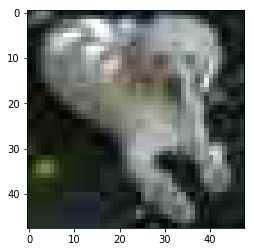

tensor([[[0.4009, 0.3757, 0.3599,  ..., 0.0764, 0.1051, 0.1689],
         [0.2324, 0.2353, 0.2374,  ..., 0.0578, 0.0841, 0.1335],
         [0.1334, 0.1291, 0.1455,  ..., 0.0816, 0.1046, 0.1462],
         ...,
         [0.1672, 0.1379, 0.1599,  ..., 0.1224, 0.1216, 0.1380],
         [0.1914, 0.1555, 0.1679,  ..., 0.1248, 0.1311, 0.1555],
         [0.2690, 0.2067, 0.2130,  ..., 0.1442, 0.1507, 0.1976]],

        [[0.3576, 0.3861, 0.3953,  ..., 0.0618, 0.0862, 0.1757],
         [0.2157, 0.2256, 0.2537,  ..., 0.0460, 0.0620, 0.1203],
         [0.1197, 0.1207, 0.1629,  ..., 0.0798, 0.0914, 0.1473],
         ...,
         [0.1662, 0.1420, 0.1850,  ..., 0.1313, 0.1205, 0.1393],
         [0.1926, 0.1581, 0.1883,  ..., 0.1370, 0.1335, 0.1566],
         [0.2324, 0.1691, 0.1861,  ..., 0.1070, 0.1172, 0.1858]],

        [[0.2981, 0.3050, 0.2841,  ..., 0.0488, 0.0707, 0.1314],
         [0.1934, 0.1875, 0.1847,  ..., 0.0361, 0.0546, 0.0997],
         [0.1083, 0.0941, 0.1019,  ..., 0.0513, 0.0727, 0.

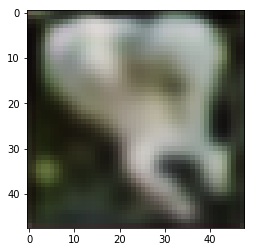


301it [00:48,  3.16it/s]
302it [00:48,  3.67it/s]
303it [00:48,  4.21it/s]
304it [00:49,  4.73it/s]
305it [00:49,  5.17it/s]
306it [00:49,  5.54it/s]
307it [00:49,  5.82it/s]
308it [00:49,  5.97it/s]
309it [00:49,  5.99it/s]
310it [00:50,  6.16it/s]
311it [00:50,  6.28it/s]
312it [00:50,  6.32it/s]
313it [00:50,  6.21it/s]
0it [00:00, ?it/s]

Epoch:  2 | train loss: 0.0075
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


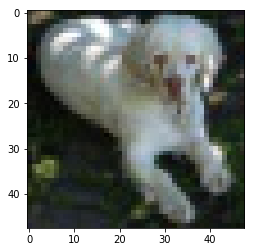

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

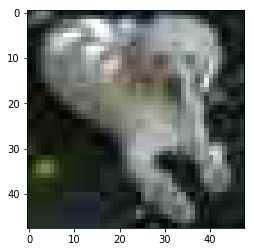

tensor([[[0.3224, 0.2758, 0.2529,  ..., 0.0419, 0.0631, 0.1227],
         [0.1705, 0.1574, 0.1560,  ..., 0.0298, 0.0463, 0.0909],
         [0.1020, 0.0935, 0.1069,  ..., 0.0506, 0.0654, 0.1071],
         ...,
         [0.1315, 0.1017, 0.1158,  ..., 0.0777, 0.0843, 0.1123],
         [0.1583, 0.1211, 0.1281,  ..., 0.0831, 0.0940, 0.1286],
         [0.2427, 0.1748, 0.1764,  ..., 0.1088, 0.1178, 0.1723]],

        [[0.2819, 0.2770, 0.2758,  ..., 0.0335, 0.0495, 0.1253],
         [0.1524, 0.1440, 0.1591,  ..., 0.0243, 0.0338, 0.0796],
         [0.0876, 0.0830, 0.1128,  ..., 0.0526, 0.0587, 0.1070],
         ...,
         [0.1290, 0.1006, 0.1268,  ..., 0.0861, 0.0852, 0.1118],
         [0.1596, 0.1183, 0.1354,  ..., 0.0937, 0.0972, 0.1273],
         [0.2007, 0.1333, 0.1418,  ..., 0.0782, 0.0893, 0.1573]],

        [[0.2524, 0.2447, 0.2213,  ..., 0.0304, 0.0466, 0.0993],
         [0.1539, 0.1412, 0.1383,  ..., 0.0217, 0.0338, 0.0708],
         [0.0904, 0.0780, 0.0874,  ..., 0.0375, 0.0524, 0.

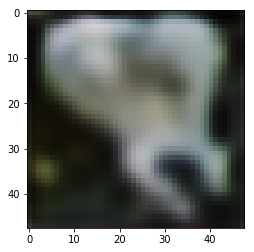


1it [00:00,  1.43it/s]
2it [00:00,  1.85it/s]
3it [00:01,  2.35it/s]
4it [00:01,  2.91it/s]
5it [00:01,  3.50it/s]
6it [00:01,  3.88it/s]
7it [00:01,  4.41it/s]
8it [00:01,  4.87it/s]
9it [00:01,  5.29it/s]
10it [00:02,  5.58it/s]
11it [00:02,  5.86it/s]
12it [00:02,  6.05it/s]
13it [00:02,  6.07it/s]
14it [00:02,  6.18it/s]
15it [00:02,  6.26it/s]
16it [00:03,  6.31it/s]
17it [00:03,  6.37it/s]
18it [00:03,  6.48it/s]
19it [00:03,  6.53it/s]
20it [00:03,  6.33it/s]
21it [00:03,  6.36it/s]
22it [00:04,  6.38it/s]
23it [00:04,  6.36it/s]
24it [00:04,  6.41it/s]
25it [00:04,  6.47it/s]
26it [00:04,  6.40it/s]
27it [00:04,  6.46it/s]
28it [00:04,  6.51it/s]
29it [00:05,  6.51it/s]
30it [00:05,  6.39it/s]
31it [00:05,  6.37it/s]
32it [00:05,  6.34it/s]
33it [00:05,  6.28it/s]
34it [00:05,  6.36it/s]
35it [00:06,  6.37it/s]
36it [00:06,  6.43it/s]
37it [00:06,  6.47it/s]
38it [00:06,  6.47it/s]
39it [00:06,  6.31it/s]
40it [00:06,  6.40it/s]
41it [00:06,  6.43it/s]
42it [00:07,  6.38it/s]


Epoch:  2 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


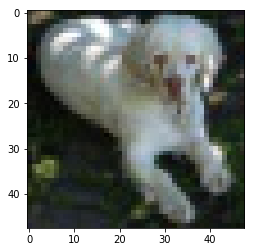

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

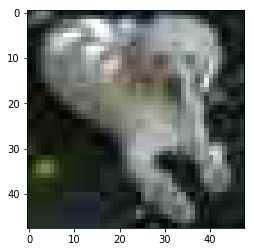

tensor([[[0.4000, 0.3577, 0.3303,  ..., 0.0495, 0.0688, 0.1253],
         [0.2137, 0.2186, 0.2174,  ..., 0.0405, 0.0586, 0.1024],
         [0.1145, 0.1119, 0.1272,  ..., 0.0646, 0.0805, 0.1192],
         ...,
         [0.1271, 0.0979, 0.1090,  ..., 0.0809, 0.0765, 0.0931],
         [0.1459, 0.1113, 0.1168,  ..., 0.0864, 0.0884, 0.1127],
         [0.2245, 0.1614, 0.1646,  ..., 0.1115, 0.1147, 0.1626]],

        [[0.3255, 0.3507, 0.3428,  ..., 0.0396, 0.0568, 0.1377],
         [0.1950, 0.1987, 0.2088,  ..., 0.0316, 0.0417, 0.0891],
         [0.1028, 0.1005, 0.1268,  ..., 0.0641, 0.0707, 0.1190],
         ...,
         [0.1151, 0.0904, 0.1151,  ..., 0.0900, 0.0787, 0.0939],
         [0.1383, 0.1043, 0.1209,  ..., 0.0997, 0.0948, 0.1133],
         [0.1806, 0.1211, 0.1342,  ..., 0.0832, 0.0902, 0.1507]],

        [[0.3095, 0.3207, 0.2831,  ..., 0.0380, 0.0555, 0.1070],
         [0.2102, 0.2073, 0.1906,  ..., 0.0301, 0.0439, 0.0796],
         [0.1165, 0.1037, 0.1045,  ..., 0.0496, 0.0670, 0.

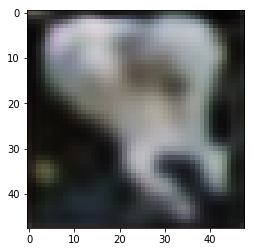


101it [00:16,  3.06it/s]
102it [00:17,  3.55it/s]
103it [00:17,  4.12it/s]
104it [00:17,  4.62it/s]
105it [00:17,  5.04it/s]
106it [00:17,  5.43it/s]
107it [00:17,  5.71it/s]
108it [00:18,  5.84it/s]
109it [00:18,  6.04it/s]
110it [00:18,  6.16it/s]
111it [00:18,  6.23it/s]
112it [00:18,  6.31it/s]
113it [00:18,  6.34it/s]
114it [00:19,  6.26it/s]
115it [00:19,  6.32it/s]
116it [00:19,  6.45it/s]
117it [00:19,  6.42it/s]
118it [00:19,  6.46it/s]
119it [00:19,  6.47it/s]
120it [00:19,  6.51it/s]
121it [00:20,  6.42it/s]
122it [00:20,  6.45it/s]
123it [00:20,  6.51it/s]
124it [00:20,  6.47it/s]
125it [00:20,  6.51it/s]
126it [00:20,  6.48it/s]
127it [00:21,  6.45it/s]
128it [00:21,  6.38it/s]
129it [00:21,  6.44it/s]
130it [00:21,  6.48it/s]
131it [00:21,  6.43it/s]
132it [00:21,  6.45it/s]
133it [00:21,  6.45it/s]
134it [00:22,  6.27it/s]
135it [00:22,  6.32it/s]
136it [00:22,  6.43it/s]
137it [00:22,  6.49it/s]
138it [00:22,  6.47it/s]
139it [00:22,  6.46it/s]
140it [00:23,  6.53it/s]

Epoch:  2 | train loss: 0.0069
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


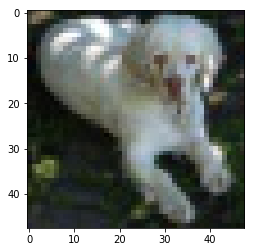

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

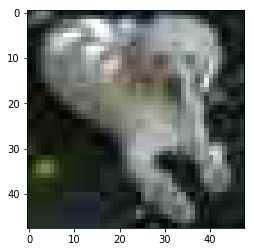

tensor([[[0.4397, 0.4407, 0.4324,  ..., 0.0616, 0.0821, 0.1394],
         [0.2255, 0.2628, 0.2813,  ..., 0.0444, 0.0638, 0.1127],
         [0.1099, 0.1241, 0.1519,  ..., 0.0667, 0.0851, 0.1312],
         ...,
         [0.1452, 0.1318, 0.1619,  ..., 0.1314, 0.1177, 0.1295],
         [0.1654, 0.1411, 0.1585,  ..., 0.1275, 0.1250, 0.1462],
         [0.2474, 0.1862, 0.1962,  ..., 0.1370, 0.1391, 0.1864]],

        [[0.3462, 0.3999, 0.4076,  ..., 0.0505, 0.0687, 0.1524],
         [0.1994, 0.2320, 0.2573,  ..., 0.0375, 0.0486, 0.0979],
         [0.0945, 0.1074, 0.1433,  ..., 0.0699, 0.0787, 0.1285],
         ...,
         [0.1276, 0.1177, 0.1591,  ..., 0.1332, 0.1137, 0.1225],
         [0.1526, 0.1293, 0.1577,  ..., 0.1350, 0.1260, 0.1387],
         [0.1943, 0.1410, 0.1628,  ..., 0.1040, 0.1116, 0.1726]],

        [[0.3065, 0.3349, 0.3141,  ..., 0.0388, 0.0555, 0.1061],
         [0.1785, 0.1880, 0.1861,  ..., 0.0243, 0.0362, 0.0715],
         [0.0867, 0.0822, 0.0898,  ..., 0.0389, 0.0548, 0.

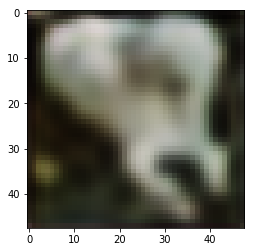


201it [00:33,  2.95it/s]
202it [00:33,  3.47it/s]
203it [00:33,  3.99it/s]
204it [00:33,  4.51it/s]
205it [00:33,  4.91it/s]
206it [00:33,  5.24it/s]
207it [00:34,  5.51it/s]
208it [00:34,  5.74it/s]
209it [00:34,  5.80it/s]
210it [00:34,  5.89it/s]
211it [00:34,  6.05it/s]
212it [00:34,  6.18it/s]
213it [00:35,  6.21it/s]
214it [00:35,  6.25it/s]
215it [00:35,  6.29it/s]
216it [00:35,  6.17it/s]
217it [00:35,  6.25it/s]
218it [00:35,  6.14it/s]
219it [00:36,  6.25it/s]
220it [00:36,  6.17it/s]
221it [00:36,  6.23it/s]
222it [00:36,  6.17it/s]
223it [00:36,  6.20it/s]
224it [00:36,  6.25it/s]
225it [00:37,  6.29it/s]
226it [00:37,  6.28it/s]
227it [00:37,  6.32it/s]
228it [00:37,  6.25it/s]
229it [00:37,  6.14it/s]
230it [00:37,  6.16it/s]
231it [00:37,  6.20it/s]
232it [00:38,  6.26it/s]
233it [00:38,  6.30it/s]
234it [00:38,  6.37it/s]
235it [00:38,  6.25it/s]
236it [00:38,  6.30it/s]
237it [00:38,  6.28it/s]
238it [00:39,  6.33it/s]
239it [00:39,  6.32it/s]
240it [00:39,  6.38it/s]

Epoch:  2 | train loss: 0.0068
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


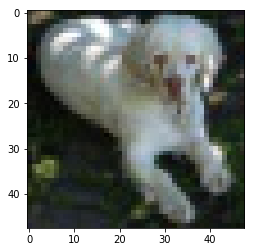

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

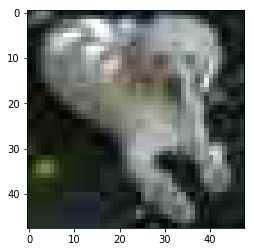

tensor([[[0.4699, 0.4424, 0.4305,  ..., 0.0718, 0.0803, 0.1238],
         [0.2446, 0.2624, 0.2707,  ..., 0.0580, 0.0668, 0.1012],
         [0.1227, 0.1329, 0.1531,  ..., 0.0861, 0.0904, 0.1213],
         ...,
         [0.1603, 0.1322, 0.1509,  ..., 0.1179, 0.0964, 0.1038],
         [0.1751, 0.1409, 0.1517,  ..., 0.1143, 0.1048, 0.1224],
         [0.2485, 0.1912, 0.2001,  ..., 0.1345, 0.1319, 0.1746]],

        [[0.4099, 0.4681, 0.4657,  ..., 0.0774, 0.0874, 0.1646],
         [0.2721, 0.3052, 0.3224,  ..., 0.0667, 0.0657, 0.1043],
         [0.1411, 0.1669, 0.2115,  ..., 0.1181, 0.1041, 0.1367],
         ...,
         [0.1635, 0.1513, 0.2000,  ..., 0.1560, 0.1161, 0.1191],
         [0.1796, 0.1590, 0.1939,  ..., 0.1516, 0.1277, 0.1345],
         [0.2190, 0.1700, 0.2000,  ..., 0.1194, 0.1192, 0.1746]],

        [[0.3881, 0.4480, 0.4221,  ..., 0.0666, 0.0778, 0.1184],
         [0.2688, 0.2966, 0.2846,  ..., 0.0535, 0.0584, 0.0812],
         [0.1428, 0.1490, 0.1531,  ..., 0.0832, 0.0879, 0.

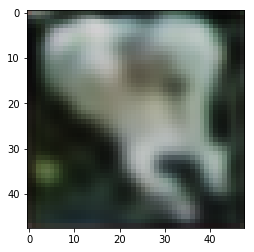


301it [00:49,  2.66it/s]
302it [00:49,  3.19it/s]
303it [00:49,  3.69it/s]
304it [00:50,  4.23it/s]
305it [00:50,  4.71it/s]
306it [00:50,  5.13it/s]
307it [00:50,  5.49it/s]
308it [00:50,  5.77it/s]
309it [00:50,  5.92it/s]
310it [00:50,  6.01it/s]
311it [00:51,  6.03it/s]
312it [00:51,  6.14it/s]
313it [00:51,  6.09it/s]
0it [00:00, ?it/s]

Epoch:  3 | train loss: 0.0062
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


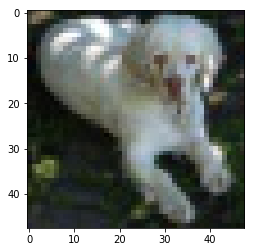

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

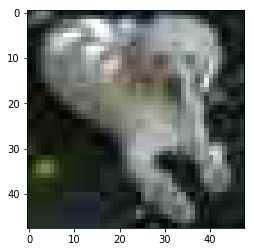

tensor([[[0.4433, 0.4369, 0.4434,  ..., 0.0652, 0.0724, 0.1129],
         [0.2269, 0.2640, 0.2944,  ..., 0.0562, 0.0638, 0.0959],
         [0.1186, 0.1419, 0.1781,  ..., 0.0949, 0.0956, 0.1224],
         ...,
         [0.1448, 0.1245, 0.1510,  ..., 0.1331, 0.1023, 0.1033],
         [0.1564, 0.1287, 0.1456,  ..., 0.1222, 0.1078, 0.1207],
         [0.2257, 0.1691, 0.1823,  ..., 0.1299, 0.1257, 0.1660]],

        [[0.3591, 0.4171, 0.4326,  ..., 0.0629, 0.0719, 0.1456],
         [0.2276, 0.2702, 0.3064,  ..., 0.0568, 0.0552, 0.0910],
         [0.1212, 0.1529, 0.2086,  ..., 0.1146, 0.0974, 0.1273],
         ...,
         [0.1389, 0.1293, 0.1787,  ..., 0.1642, 0.1152, 0.1118],
         [0.1522, 0.1351, 0.1706,  ..., 0.1548, 0.1260, 0.1282],
         [0.1902, 0.1424, 0.1708,  ..., 0.1151, 0.1133, 0.1661]],

        [[0.3398, 0.3934, 0.3824,  ..., 0.0523, 0.0622, 0.0989],
         [0.2203, 0.2490, 0.2549,  ..., 0.0417, 0.0459, 0.0659],
         [0.1194, 0.1294, 0.1444,  ..., 0.0736, 0.0768, 0.

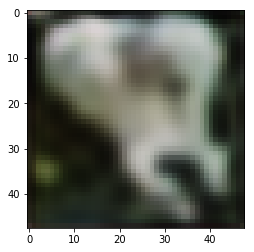


1it [00:00,  1.44it/s]
2it [00:00,  1.87it/s]
3it [00:01,  2.38it/s]
4it [00:01,  2.95it/s]
5it [00:01,  3.46it/s]
6it [00:01,  3.99it/s]
7it [00:01,  4.51it/s]
8it [00:01,  4.97it/s]
9it [00:01,  5.37it/s]
10it [00:02,  5.71it/s]
11it [00:02,  5.90it/s]
12it [00:02,  6.07it/s]
13it [00:02,  6.11it/s]
14it [00:02,  6.15it/s]
15it [00:02,  6.28it/s]
16it [00:03,  6.31it/s]
17it [00:03,  6.33it/s]
18it [00:03,  6.42it/s]
19it [00:03,  6.53it/s]
20it [00:03,  6.41it/s]
21it [00:03,  6.37it/s]
22it [00:03,  6.38it/s]
23it [00:04,  6.43it/s]
24it [00:04,  6.49it/s]
25it [00:04,  6.48it/s]
26it [00:04,  6.39it/s]
27it [00:04,  6.48it/s]
28it [00:04,  6.51it/s]
29it [00:05,  6.53it/s]
30it [00:05,  6.50it/s]
31it [00:05,  6.57it/s]
32it [00:05,  6.50it/s]
33it [00:05,  6.41it/s]
34it [00:05,  6.41it/s]
35it [00:05,  6.46it/s]
36it [00:06,  6.53it/s]
37it [00:06,  6.58it/s]
38it [00:06,  6.59it/s]
39it [00:06,  6.60it/s]
40it [00:06,  6.50it/s]
41it [00:06,  6.59it/s]
42it [00:07,  6.56it/s]


Epoch:  3 | train loss: 0.0066
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


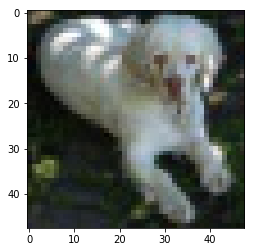

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

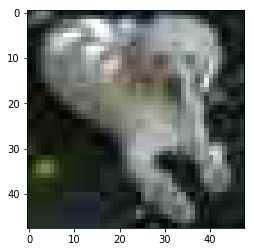

tensor([[[0.4354, 0.4316, 0.4340,  ..., 0.0597, 0.0670, 0.1074],
         [0.2063, 0.2519, 0.2822,  ..., 0.0566, 0.0657, 0.0980],
         [0.0962, 0.1209, 0.1548,  ..., 0.0991, 0.1038, 0.1319],
         ...,
         [0.1282, 0.1150, 0.1412,  ..., 0.1114, 0.0937, 0.1040],
         [0.1409, 0.1221, 0.1427,  ..., 0.1099, 0.1024, 0.1227],
         [0.2139, 0.1661, 0.1851,  ..., 0.1277, 0.1266, 0.1712]],

        [[0.3493, 0.4231, 0.4391,  ..., 0.0595, 0.0686, 0.1406],
         [0.2016, 0.2582, 0.2964,  ..., 0.0560, 0.0560, 0.0950],
         [0.0939, 0.1285, 0.1797,  ..., 0.1167, 0.1040, 0.1381],
         ...,
         [0.1146, 0.1150, 0.1624,  ..., 0.1231, 0.0964, 0.1103],
         [0.1286, 0.1233, 0.1608,  ..., 0.1249, 0.1101, 0.1265],
         [0.1696, 0.1339, 0.1683,  ..., 0.1103, 0.1129, 0.1723]],

        [[0.3493, 0.4266, 0.4149,  ..., 0.0485, 0.0577, 0.0936],
         [0.2219, 0.2787, 0.2908,  ..., 0.0440, 0.0485, 0.0689],
         [0.1107, 0.1370, 0.1580,  ..., 0.0814, 0.0860, 0.

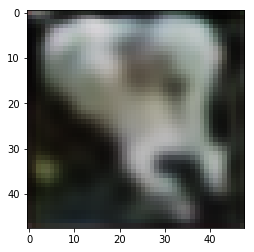


101it [00:16,  3.05it/s]
102it [00:17,  3.55it/s]
103it [00:17,  4.08it/s]
104it [00:17,  4.57it/s]
105it [00:17,  5.03it/s]
106it [00:17,  5.36it/s]
107it [00:17,  5.50it/s]
108it [00:18,  5.74it/s]
109it [00:18,  5.86it/s]
110it [00:18,  6.04it/s]
111it [00:18,  6.04it/s]
112it [00:18,  6.16it/s]
113it [00:18,  6.26it/s]
114it [00:19,  6.21it/s]
115it [00:19,  6.27it/s]
116it [00:19,  6.26it/s]
117it [00:19,  6.29it/s]
118it [00:19,  6.24it/s]
119it [00:19,  6.24it/s]
120it [00:20,  6.14it/s]
121it [00:20,  6.15it/s]
122it [00:20,  6.19it/s]
123it [00:20,  6.31it/s]
124it [00:20,  6.35it/s]
125it [00:20,  6.42it/s]
126it [00:20,  6.40it/s]
127it [00:21,  6.23it/s]
128it [00:21,  6.26it/s]
129it [00:21,  6.31it/s]
130it [00:21,  6.41it/s]
131it [00:21,  6.47it/s]
132it [00:21,  6.51it/s]
133it [00:22,  6.41it/s]
134it [00:22,  6.37it/s]
135it [00:22,  6.08it/s]
136it [00:22,  6.20it/s]
137it [00:22,  6.31it/s]
138it [00:22,  6.32it/s]
139it [00:23,  6.35it/s]
140it [00:23,  6.30it/s]

Epoch:  3 | train loss: 0.0064
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


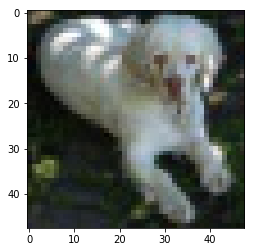

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

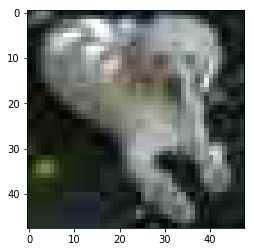

tensor([[[0.4602, 0.4501, 0.4504,  ..., 0.0539, 0.0544, 0.0828],
         [0.2431, 0.2911, 0.3144,  ..., 0.0498, 0.0515, 0.0744],
         [0.1255, 0.1599, 0.1908,  ..., 0.0991, 0.0961, 0.1170],
         ...,
         [0.1455, 0.1255, 0.1450,  ..., 0.1076, 0.0820, 0.0863],
         [0.1554, 0.1304, 0.1446,  ..., 0.1029, 0.0895, 0.1053],
         [0.2247, 0.1671, 0.1775,  ..., 0.1132, 0.1081, 0.1518]],

        [[0.3599, 0.4192, 0.4257,  ..., 0.0541, 0.0561, 0.1140],
         [0.2321, 0.2756, 0.3008,  ..., 0.0500, 0.0434, 0.0704],
         [0.1203, 0.1551, 0.2010,  ..., 0.1162, 0.0927, 0.1161],
         ...,
         [0.1339, 0.1245, 0.1615,  ..., 0.1187, 0.0815, 0.0854],
         [0.1462, 0.1317, 0.1605,  ..., 0.1162, 0.0934, 0.1003],
         [0.1804, 0.1361, 0.1626,  ..., 0.0973, 0.0956, 0.1461]],

        [[0.3410, 0.4026, 0.3858,  ..., 0.0420, 0.0460, 0.0719],
         [0.2270, 0.2677, 0.2651,  ..., 0.0357, 0.0352, 0.0479],
         [0.1210, 0.1418, 0.1503,  ..., 0.0736, 0.0721, 0.

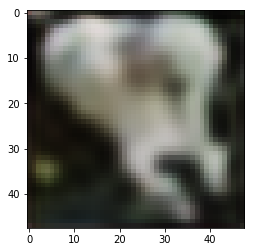


201it [00:33,  3.14it/s]
202it [00:33,  3.60it/s]
203it [00:33,  4.14it/s]
204it [00:33,  4.64it/s]
205it [00:33,  5.08it/s]
206it [00:34,  5.45it/s]
207it [00:34,  5.76it/s]
208it [00:34,  5.98it/s]
209it [00:34,  6.03it/s]
210it [00:34,  6.15it/s]
211it [00:34,  6.29it/s]
212it [00:34,  6.34it/s]
213it [00:35,  6.46it/s]
214it [00:35,  6.48it/s]
215it [00:35,  6.39it/s]
216it [00:35,  6.41it/s]
217it [00:35,  6.45it/s]
218it [00:35,  6.48it/s]
219it [00:36,  6.57it/s]
220it [00:36,  6.57it/s]
221it [00:36,  6.57it/s]
222it [00:36,  6.47it/s]
223it [00:36,  6.51it/s]
224it [00:36,  6.51it/s]
225it [00:36,  6.56it/s]
226it [00:37,  6.53it/s]
227it [00:37,  6.58it/s]
228it [00:37,  6.54it/s]
229it [00:37,  6.46it/s]
230it [00:37,  6.45it/s]
231it [00:37,  6.46it/s]
232it [00:38,  6.40it/s]
233it [00:38,  6.46it/s]
234it [00:38,  6.46it/s]
235it [00:38,  6.32it/s]
236it [00:38,  6.42it/s]
237it [00:38,  6.46it/s]
238it [00:38,  6.54it/s]
239it [00:39,  6.60it/s]
240it [00:39,  6.62it/s]

Epoch:  3 | train loss: 0.0064
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


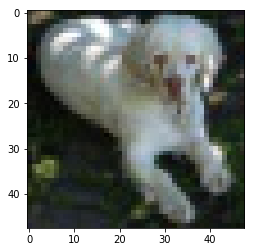

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

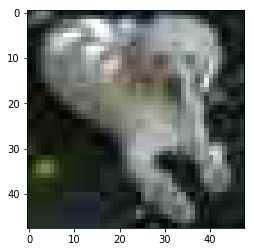

tensor([[[0.4884, 0.5016, 0.5060,  ..., 0.0863, 0.0827, 0.1113],
         [0.2524, 0.3190, 0.3379,  ..., 0.0768, 0.0807, 0.1068],
         [0.1204, 0.1562, 0.1754,  ..., 0.1280, 0.1360, 0.1629],
         ...,
         [0.1421, 0.1278, 0.1485,  ..., 0.0974, 0.0798, 0.0886],
         [0.1481, 0.1307, 0.1495,  ..., 0.0927, 0.0844, 0.1040],
         [0.2119, 0.1631, 0.1793,  ..., 0.1031, 0.0996, 0.1484]],

        [[0.3816, 0.4696, 0.4834,  ..., 0.0964, 0.0945, 0.1607],
         [0.2381, 0.3091, 0.3340,  ..., 0.0860, 0.0751, 0.1099],
         [0.1159, 0.1576, 0.1922,  ..., 0.1603, 0.1401, 0.1711],
         ...,
         [0.1335, 0.1343, 0.1752,  ..., 0.1168, 0.0848, 0.0920],
         [0.1400, 0.1387, 0.1745,  ..., 0.1118, 0.0926, 0.1025],
         [0.1732, 0.1390, 0.1722,  ..., 0.0964, 0.0934, 0.1454]],

        [[0.3688, 0.4579, 0.4500,  ..., 0.0702, 0.0728, 0.1000],
         [0.2405, 0.3090, 0.3066,  ..., 0.0580, 0.0573, 0.0724],
         [0.1227, 0.1529, 0.1540,  ..., 0.0998, 0.1041, 0.

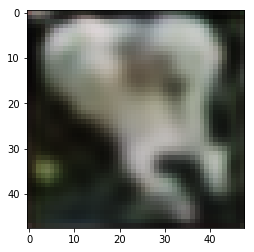


301it [00:49,  3.16it/s]
302it [00:49,  3.68it/s]
303it [00:49,  4.20it/s]
304it [00:49,  4.65it/s]
305it [00:49,  5.12it/s]
306it [00:50,  5.47it/s]
307it [00:50,  5.73it/s]
308it [00:50,  6.03it/s]
309it [00:50,  6.23it/s]
310it [00:50,  6.34it/s]
311it [00:50,  6.29it/s]
312it [00:51,  6.38it/s]
313it [00:51,  6.12it/s]
0it [00:00, ?it/s]

Epoch:  4 | train loss: 0.0054
torch.Size([1, 3, 48, 48])
tensor([[[0.2353, 0.3686, 0.4902,  ..., 0.1098, 0.0980, 0.0980],
         [0.3137, 0.4745, 0.4745,  ..., 0.1333, 0.1490, 0.1725],
         [0.3216, 0.4549, 0.3608,  ..., 0.1882, 0.1765, 0.1765],
         ...,
         [0.1647, 0.1804, 0.1451,  ..., 0.0863, 0.0863, 0.0667],
         [0.1765, 0.1765, 0.1608,  ..., 0.0863, 0.0706, 0.0902],
         [0.1451, 0.1686, 0.1686,  ..., 0.0667, 0.0431, 0.0667]],

        [[0.2196, 0.3333, 0.4314,  ..., 0.0980, 0.0745, 0.0745],
         [0.3020, 0.4471, 0.4235,  ..., 0.1373, 0.1412, 0.1569],
         [0.3137, 0.4314, 0.3333,  ..., 0.2039, 0.1882, 0.1922],
         ...,
         [0.1725, 0.1882, 0.1647,  ..., 0.1176, 0.1333, 0.1216],
         [0.1804, 0.1804, 0.1686,  ..., 0.1176, 0.1098, 0.1294],
         [0.1451, 0.1725, 0.1765,  ..., 0.0980, 0.0667, 0.0863]],

        [[0.1725, 0.2667, 0.3412,  ..., 0.1255, 0.1137, 0.1216],
         [0.2431, 0.3765, 0.3490,  ..., 0.1529, 0.1529, 0.1529],


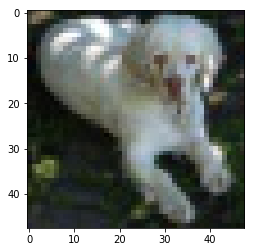

tensor([[[0.1333, 0.2745, 0.4392,  ..., 0.0471, 0.0588, 0.0627],
         [0.2588, 0.3333, 0.4039,  ..., 0.1020, 0.0902, 0.0706],
         [0.3059, 0.3020, 0.2745,  ..., 0.1529, 0.1255, 0.0863],
         ...,
         [0.1333, 0.1333, 0.1333,  ..., 0.1176, 0.1098, 0.1059],
         [0.1373, 0.1373, 0.1373,  ..., 0.0863, 0.0706, 0.0549],
         [0.1412, 0.1412, 0.1412,  ..., 0.0549, 0.0275, 0.0078]],

        [[0.1765, 0.3176, 0.4824,  ..., 0.0902, 0.1020, 0.1059],
         [0.3020, 0.3765, 0.4471,  ..., 0.1451, 0.1333, 0.1137],
         [0.3490, 0.3451, 0.3176,  ..., 0.1961, 0.1686, 0.1294],
         ...,
         [0.1843, 0.1843, 0.1804,  ..., 0.1608, 0.1529, 0.1490],
         [0.1882, 0.1843, 0.1843,  ..., 0.1294, 0.1137, 0.0980],
         [0.1882, 0.1882, 0.1882,  ..., 0.0980, 0.0706, 0.0510]],

        [[0.1608, 0.3020, 0.4667,  ..., 0.0745, 0.0863, 0.0902],
         [0.2863, 0.3608, 0.4314,  ..., 0.1294, 0.1176, 0.0980],
         [0.3333, 0.3294, 0.3020,  ..., 0.1804, 0.1529, 0.

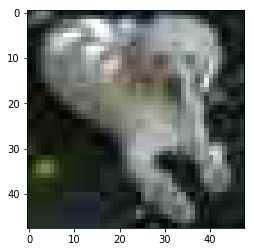

tensor([[[0.4708, 0.4629, 0.4586,  ..., 0.0620, 0.0608, 0.0889],
         [0.2489, 0.2942, 0.3028,  ..., 0.0501, 0.0540, 0.0788],
         [0.1231, 0.1492, 0.1630,  ..., 0.0904, 0.0963, 0.1241],
         ...,
         [0.1373, 0.1222, 0.1446,  ..., 0.1025, 0.0797, 0.0840],
         [0.1426, 0.1247, 0.1445,  ..., 0.0940, 0.0809, 0.0949],
         [0.2045, 0.1535, 0.1693,  ..., 0.0967, 0.0918, 0.1349]],

        [[0.3839, 0.4526, 0.4566,  ..., 0.0751, 0.0736, 0.1322],
         [0.2470, 0.2976, 0.3129,  ..., 0.0643, 0.0556, 0.0855],
         [0.1247, 0.1579, 0.1890,  ..., 0.1317, 0.1116, 0.1391],
         ...,
         [0.1303, 0.1312, 0.1758,  ..., 0.1240, 0.0863, 0.0930],
         [0.1352, 0.1343, 0.1738,  ..., 0.1161, 0.0913, 0.1001],
         [0.1683, 0.1342, 0.1698,  ..., 0.0966, 0.0903, 0.1402]],

        [[0.3511, 0.4176, 0.3989,  ..., 0.0503, 0.0531, 0.0792],
         [0.2331, 0.2760, 0.2644,  ..., 0.0390, 0.0390, 0.0535],
         [0.1204, 0.1377, 0.1349,  ..., 0.0730, 0.0760, 0.

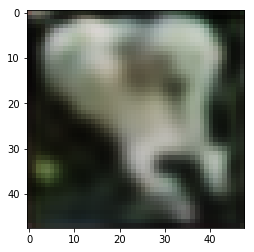


1it [00:00,  1.45it/s]
2it [00:00,  1.87it/s]
3it [00:01,  2.39it/s]

In [0]:
in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder()
# rednet = REDNet10()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()


for epoch in range(epochs):
    autoencoder.train()
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):

        encoded, decoded = autoencoder(x) 
#         decoded = rednet(x)
        loss = loss_func(decoded, y)
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0:# and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())
#             decoded_data = rednet(original_data)
            _, decoded_data = autoencoder(original_data)
            print(in_data.shape)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))

In [0]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                ]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader): 
    _,de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    
sampled_z = np.concatenate(decoded_samples, axis=0)


def save_result(images: np.ndarray, out_path: str):
    assert images.shape == (400, 3, 48, 48)
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,predicted", comments='')
    
save_result(sampled_z, 'solution.txt')
show_img(x[0].squeeze(0))
show_img(de_x[0].data.squeeze(0))
